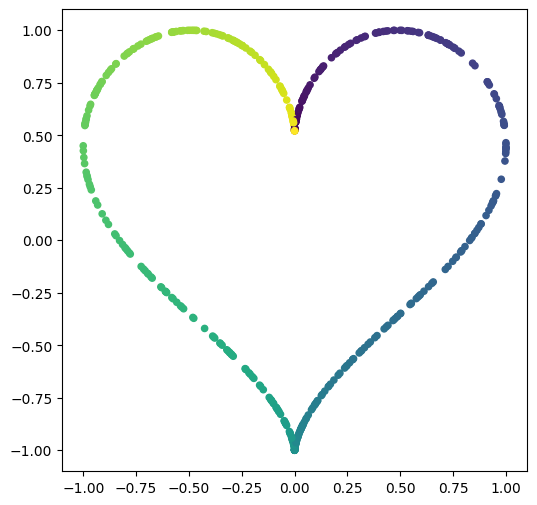

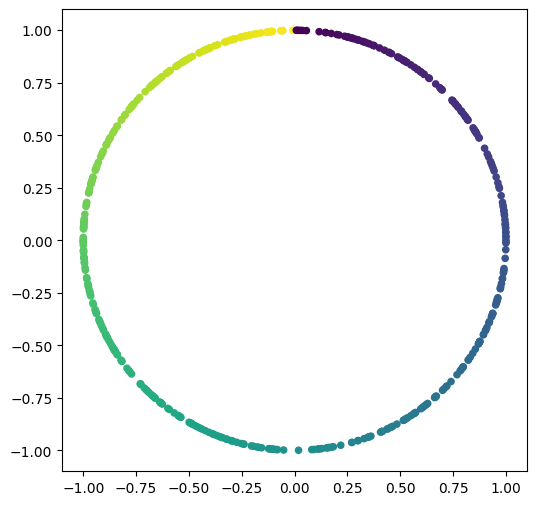

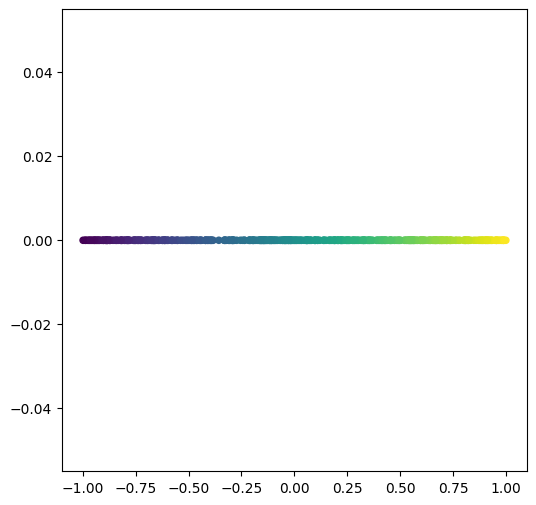

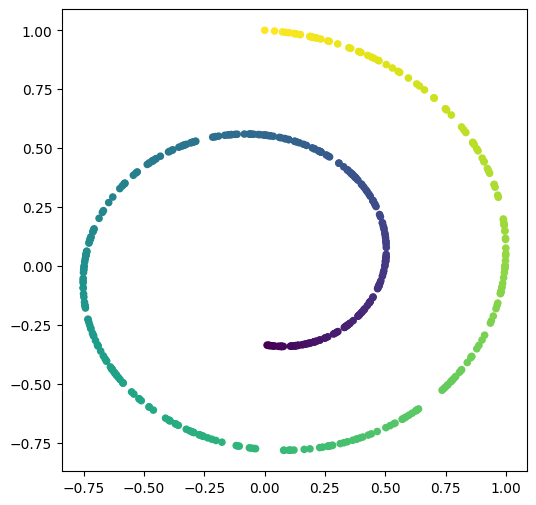

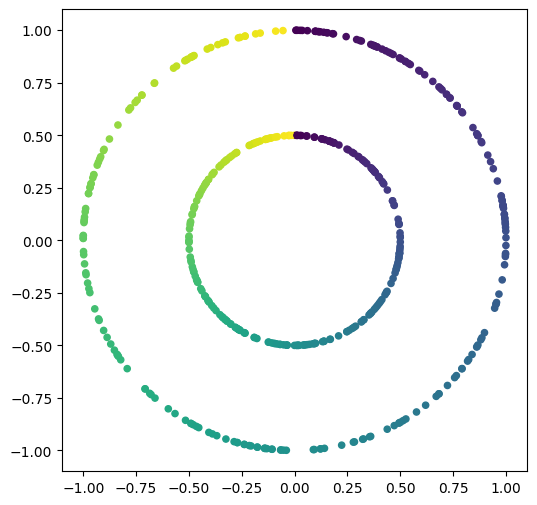

In [ ]:
import  numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

# generate two datsets
def generateHeart(num_points):

  #source
  #https://medium.com/the-stata-guide/i-stata-391736dc6bad

  #t = np.linspace(0, np.pi*2, num_points+1)[:-1]

  t = 2*np.pi * np.random.random_sample(num_points)
  x = np.sin(t)**3  #+ np.random.normal(0,0.05, num_points)
  y = 13*np.cos(t)-5*np.cos(2*t)-2*np.cos(3*t)-np.cos(4*t) #+ np.random.normal(0,0.05, num_points)

  # rescale
  y += (np.abs(np.min(y)) - np.max(y))/2
  y /= np.max(y)

  # x points, y points and colors
  return np.array([x,y,t]).T


def generateCircle(num_points):
  t = 2*np.pi * np.random.random_sample(num_points)
  #t = np.linspace(0, np.pi*2, num_points+1)[:-1]
  x = np.sin(t) #+ 2#+ np.random.normal(0,0.05, num_points)
  y = np.cos(t) #+ np.random.normal(0,0.05, num_points)

  return np.array([x,y,t]).T

def generateLine(num_points):
  x = 2 * np.random.random_sample(num_points) - 1
  #x = np.linspace(-1, 1, num_points)
  y = np.zeros(num_points) #+ np.random.normal(0,0.05, num_points)

  return np.array([x,y,x]).T

def generateSwirl(num_points):

  data =  datasets.make_swiss_roll(n_samples = num_points)
  return np.hstack((np.hstack((data[0][:,:1]/np.max(np.abs(data[0][:,:1])), data[0][:,2:]/np.max(np.abs(data[0][:,2:])))), np.reshape(data[1], (num_points,1))))

def generateCircles(num_points):
  t = 2*np.pi * np.random.random_sample(num_points)
  #t = np.linspace(0, np.pi*2, num_points+1)[:-1]
  x = np.sin(t) #+ 2#+ np.random.normal(0,0.05, num_points)
  y = np.cos(t) #+ np.random.normal(0,0.05, num_points)
  half = int(num_points/2)
  x[:half] = x[:half]*2
  y[:half] = y[:half]*2
  return np.array([x,y,t]).T


def plot(X):

  fig, ax = plt.subplots(figsize=(6, 6))
  #ax.set(xlim=(-1.3, 1.3), ylim=(-1.3, 1.3))
  ax.scatter(X[:,0],X[:,1], c=X[:,2], s=20.0)

n = 500
heart = generateHeart(n)
circle = generateCircle(n)
line = generateLine(n)
swirl = generateSwirl(n)
circles = generateCircles(n)

h_c = heart[:,2:]
c_c = circle[:,2:]
l_c = line[:,2:]
plot(heart)
plot(circle)
plot(line)
plot(swirl)
plot(circles)
#np.savetxt("hearts.txt", hearts[:,:2].astype('float32'), header=(str(n)))
#np.savetxt("circles.txt", circles[:,:2].astype('float32'), header=(str(n)))

#X = np.genfromtxt("outhearts.txt", dtype='float')
#print(X)
#plot(np.hstack((X,hearts_c)))


early stop 10 2.1457344368072988e-16
early stop 60 8.661465803486097e-16
maxed out 1.0295870330746255e-11


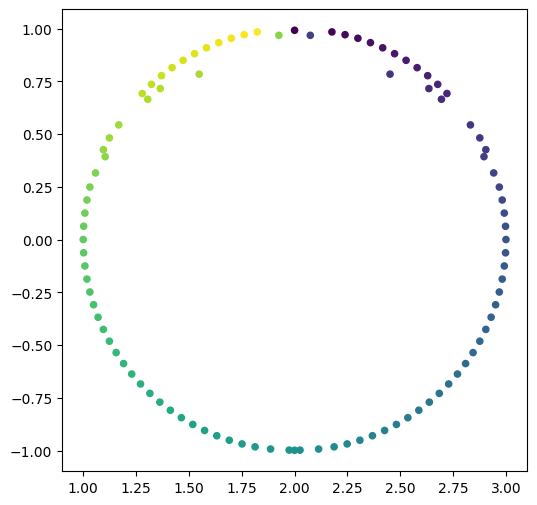

In [ ]:
import numpy as np

def sinkhorn(x, y, a, b, epsf, tau, numIter, stop, numEps):

  m = np.shape(x)[0]
  n = np.shape(y)[0]
  dim = np.shape(x)[1]
  x = x[:,None,:]
  y = y[None,:,:]

  if not a:
    a = np.full((m,1), 1.0/m)
  if not b:
    b = np.full((n,1), 1.0/n)

  u = np.full((m,1), 1.0)
  v = np.full((n,1), 1.0)
  alpha = np.log(u)
  beta = np.log(v).T

  orig_u = u
  orig_v = v
  eps0 = 100
  lam = (epsf/eps0)**(1/numEps)
  eps = eps0*(lam**1)

  for j in range(1,numEps+1):

    eps = eps0*(lam**j)
    K = np.exp((np.sum((x-y)**2, 2)*-1 + alpha + beta)/eps)
    for i in range(numIter):

      v = b/(K.T @ u)
      u = a/(K@v)

      logu = np.log(u)
      logv = np.log(v).T

      alpha += logu*eps
      beta += logv * eps

      u = orig_u
      v = orig_v

      if i%10 == 0:
        G = np.exp((np.sum((x-y)**2, 2)*-1 + alpha + beta)/eps + logu + logv)
        err = np.linalg.norm(np.sum(G, axis=1) - a)

        if err < stop:
          print("early stop", i, err)
          break

      K = np.exp((np.sum((x-y)**2, 2)*-1 + alpha + beta)/eps)


  print("maxed out", err)
  return G

G = sinkhorn(circle[:,:2], heart[:,:2], None, None, 0.0001, 0, 1000, 1e-15, 5)
new_d =  G @ circles *n # heart -> cirlce mapping
plot(np.hstack((new_d[:,:2], h_c)))


early stop 10 8.719034961300418e-16
early stop 20 7.851378622334145e-15
maxed out 4.0565312261660825e-08


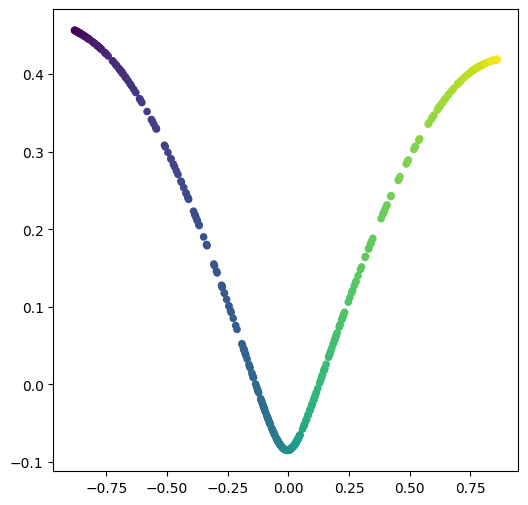

In [ ]:
import torch

def sinkhorn(x_orig, y_orig, a, b, epsf, tau, numIter, stop, numEps):

  m = np.shape(x_orig)[0]
  n = np.shape(y_orig)[0]
  dim = np.shape(x_orig)[1]
  torch.set_default_dtype(torch.float64)
  x_orig = torch.from_numpy(x_orig)
  y_orig = torch.from_numpy(y_orig)
  x = x_orig[:,None,:]
  y = y_orig[None,:,:]

  if not a:
    a = torch.full((m,1), 1.0/m)
  if not b:
    b = torch.full((n,1), 1.0/n)

  u = torch.full((m,1), 1.0)
  v = torch.full((n,1), 1.0)

  alpha = torch.log(u)
  beta = torch.transpose(torch.log(v), 0, 1)

  orig_u = u
  orig_v = v
  eps0 = 100
  lam = (epsf/eps0)**(1/numEps)

  for j in range(1,numEps+1):

    eps = eps0*(lam**j)

    K = torch.exp(torch.div(torch.add(torch.mul(torch.sum(torch.pow(torch.sub(x,y), 2),2),-1), torch.add(alpha, beta)), eps))
    for i in range(numIter):

      v = torch.div(b, (torch.matmul(torch.transpose(K, 0, 1), u)))
      u = torch.div(a, (torch.matmul(K, v)))#a/(K@v.T)

      logu = torch.log(u)
      logv = torch.transpose(torch.log(v), 0, 1)

      alpha = torch.add(alpha, torch.mul(logu, eps))
      beta = torch.add(beta, torch.mul(logv, eps))

      u = orig_u
      v = orig_v

      if i%10 == 0:
        G = torch.exp(torch.add(torch.div(torch.add(torch.mul(torch.sum(torch.pow(torch.sub(x,y), 2),2),-1), torch.add(alpha, beta)), eps), torch.add(logu, logv)))
        err = torch.linalg.norm(torch.sub(torch.sum(G, axis=0), b)).item()

        if err < stop:
          print("early stop", i, err)

          break

      K = torch.exp(torch.div(torch.add(torch.mul(torch.sum(torch.pow(torch.sub(x,y), 2),2),-1), torch.add(alpha, beta)), eps))
    #x_orig = torch.mul(torch.matmul(G, y_orig), n)
    #x = x_orig[:,None,:]
    #plot(np.hstack((x_orig.numpy(), h_c)))

  print("maxed out", err)
  return G.numpy()


G = sinkhorn(line[:,:2], heart[:,:2], None, None, 0.1, 0, 100, 1e-13, 3)
new_d =  G @ heart *n # heart -> cirlce mapping

plot(np.hstack((new_d[:,:2], l_c)))

#G = sinkhorn(new_d[:,:2], circles[:,:2], None, None, 0.00001, 0, 100, 1e-13, 5)
#new_d =  G @ circles *n # heart -> cirlce mapping
#plot(np.hstack((new_d[:,:2], l_c)))


In [ ]:
G = sinkhorn(heart[:,:2], circle[:,:2], None, None, 1, 0, 1000, 1e-10, 1)
new_d =  G @ circle * n  # heart -> cirlce mapping

#plt.scatter(new_d[:,0], new_d[:,1], c=h_c)
#plt.scatter(line[:,0], line[:,1], c='gray')

#plot(heart)

early stop 30 1.1325786219163957e-12
maxed out 1.1325786219163957e-12


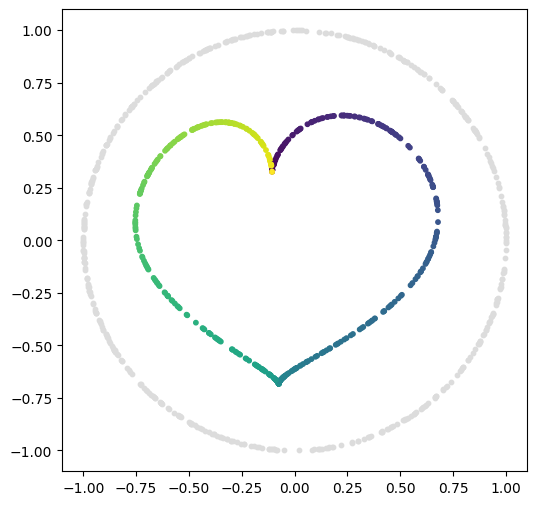

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(circle[:,0], circle[:,1], c='gainsboro', s=10.0)

ax.scatter(new_d[:,0], new_d[:,1], c=heart[:,2:], s=10.0)


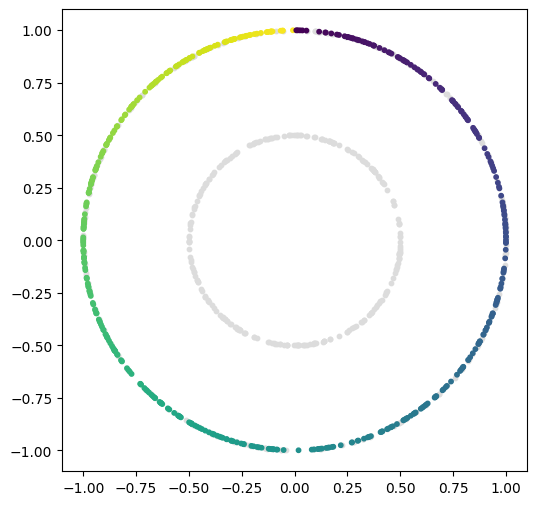

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(circles[:,0], circles[:,1], c='gainsboro', s=10.0)

ax.scatter(circle[:,0], circle[:,1], c=circle[:,2], s=10.0)


In [ ]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 15.3 MB/s eta 0:00:00


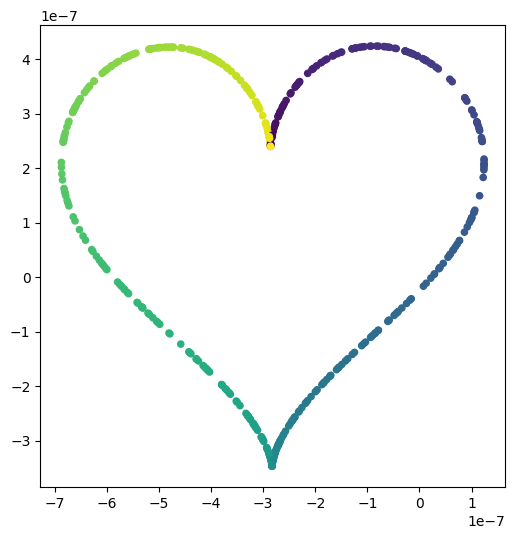

In [ ]:
import ot

x = heart[:,:2]
y = circle[:,:2]
m = np.shape(x)[0]
n = np.shape(y)[0]
dim = np.shape(x)[1]
a = np.full(m, 1.0/m)
b = np.full(n, 1.0/n)

x = np.reshape(x, (m, 1, dim))
y = np.reshape(y, (1, n,  dim))

M = np.sum((x-y)**2, 2)
P = ot.sinkhorn(a, b, M, 10, numIterMax=1000, stopThr=10, method='sinkhorn_epsilon_scaling')
new_d =  P @ circle  *n # heart -> cirlce mapping
plot(np.hstack((new_d[:,:2], h_c)))



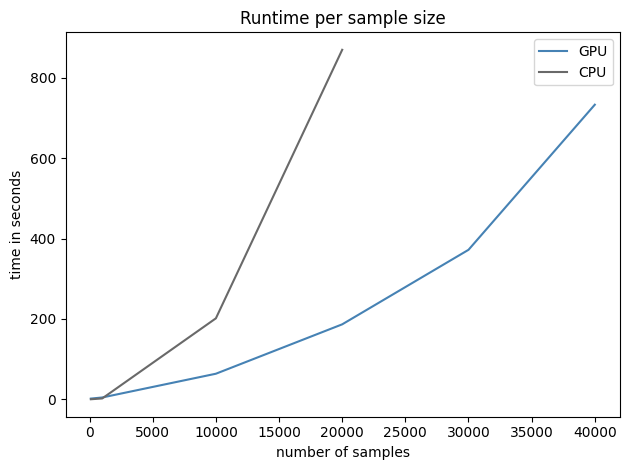

In [ ]:
t = np.array([100,1000,10000, 20000, 30000, 40000])
z = np.array([0.01916, 2.0151, 201.43210, 869.736])
s = np.array([1.68, 4.4124, 63.54689, 186.4609, 371.932, 733.1133])
fig, ax = plt.subplots()

ax.plot(t,s,label='GPU', color='steelblue')
ax.plot(t[:-2], z, label='CPU', color='dimgrey')

plt.xlabel('number of samples')
plt.ylabel('time in seconds')
plt.title('Runtime per sample size')

plt.legend()

plt.tight_layout()
plt.show()


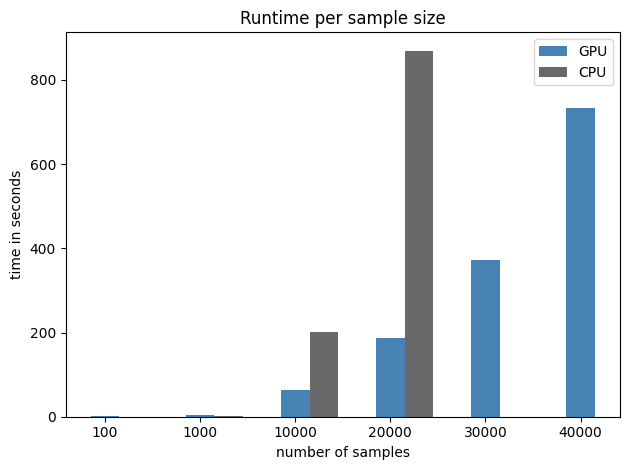

In [ ]:
t = (100,1000,10000, 20000, 30000, 40000)
z = [0.01916, 2.0151, 201.43210, 869.736]
s = np.array([1.68, 4.4124, 63.54689, 186.4609, 371.932, 733.1133])
fig, ax = plt.subplots()

p = np.arange(6)

ax.bar(p,s, width=0.3, label='GPU', color='steelblue')
ax.bar(np.arange(4) + 0.3,z, width=0.3, label='CPU', color='dimgrey')

plt.xlabel('number of samples')
plt.ylabel('time in seconds')
plt.title('Runtime per sample size')
plt.xticks(p, t)

plt.legend()

plt.tight_layout()
plt.show()
